# Exercise 2: Naive Bayes (MNIST) — Probable  Solution

## [xil88yaj], [fas94dod]


In [13]:

# 0) Imports, Data Loading, and Helper Functions
import warnings
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import KFold
from sklearn.datasets import fetch_openml
from IPython import get_ipython
import psutil

%matplotlib inline

def nextplot():
    plt.figure(figsize=(6, 6))

def showdigit(x):
    plt.imshow(x.reshape(28, 28), norm=mpl.colors.Normalize(0, 255), cmap='gray')
    plt.axis('off')

def showdigits(X, y, max_digits=15):
    y = np.asarray(y).astype(int)
    num_cols = min(max_digits, int(np.max(np.bincount(y))))
    plt.gcf().set_size_inches(max(8, num_cols), 10)
    for c in range(10):
        ii = np.where(y == c)[0]
        if len(ii) > max_digits:
            ii = np.random.choice(ii, size=max_digits, replace=False)
        for j in range(num_cols):
            ax = plt.gcf().add_subplot(10, num_cols, c * num_cols + j + 1, aspect='equal')
            ax.get_xaxis().set_visible(False)
            if j == 0:
                ax.set_ylabel(c)
                ax.set_yticks([])
            else:
                ax.get_yaxis().set_visible(False)
            if j < len(ii):
                ax.imshow(X[ii[j], :].reshape(28, 28), norm=mpl.colors.Normalize(0, 255), cmap='gray')
            else:
                ax.axis('off')

# Load MNIST
mndata = fetch_openml('mnist_784', version=1, as_frame=False)
X = mndata.data.astype(np.uint16)
y = mndata.target.astype(np.int64)
N, D = X.shape

np.random.seed(42)
indices = np.random.permutation(N)
X = X[indices]
y = y[indices]
X_train, y_train = X[:60000], y[:60000]
X_test,  y_test  = X[60000:], y[60000:]

# Small subset for prototyping
train_size = 600
test_size = 100
p_train = []
for c in range(10):
    idx_c = np.where(y_train == c)[0]
    p_train.append(np.random.choice(idx_c, size=train_size // 10, replace=False))
X_s, y_s = X_train[np.concatenate(p_train)], y_train[np.concatenate(p_train)]

p_test = []
for c in range(10):
    idx_c = np.where(y_test == c)[0]
    p_test.append(np.random.choice(idx_c, size=test_size // 10, replace=False))
Xtest_s, ytest_s = X_test[np.concatenate(p_test)], y_test[np.concatenate(p_test)]
print(f'Using {X_s.shape[0]} training and {Xtest_s.shape[0]} test samples (small subset).')

# Tiny example dataset for tests
Xex = np.array([1,0,0,1,1,1,2,0]).reshape(4,2)
yex = np.array([0,1,2,0])


Using 600 training and 100 test samples (small subset).


## 1) Training — nb_train

In [14]:

def nb_train(X, y, alpha=1, K=None, C=None):
    X = np.asarray(X)
    y = np.asarray(y).astype(int)
    N, D = X.shape
    if K is None:
        K = int(np.max(X)) + 1
    if C is None:
        C = int(np.max(y)) + 1

    counts_c = np.bincount(y, minlength=C).astype(np.int64)
    priors = (counts_c + (alpha - 1)) / (N + C * (alpha - 1))

    cls_counts = np.zeros((C, D, K), dtype=np.int64)
    for c in range(C):
        idx = np.where(y == c)[0]
        if idx.size == 0:
            continue
        Xc = X[idx, :]
        for j in range(D):
            vals, val_counts = np.unique(Xc[:, j], return_counts=True)
            mask = (vals >= 0) & (vals < K)
            cls_counts[c, j, vals[mask]] = val_counts[mask]

    cls = np.zeros((C, D, K), dtype=np.float64)
    for c in range(C):
        Nc = counts_c[c]
        denom = Nc + K * (alpha - 1)
        if denom == 0:
            continue
        cls[c, :, :] = (cls_counts[c, :, :] + (alpha - 1)) / denom

    with np.errstate(divide='warn'):
        return dict(logpriors=np.log(priors), logcls=np.log(cls))


In [15]:

# Expect warnings when alpha=1 (no smoothing)
model = nb_train(Xex, yex, alpha=1)
model


C:\Users\t00002k9\AppData\Local\Temp\ipykernel_2240\453640863.py:33: RuntimeWarning: divide by zero encountered in log
  return dict(logpriors=np.log(priors), logcls=np.log(cls))


{'logpriors': array([-0.69314718, -1.38629436, -1.38629436]),
 'logcls': array([[[       -inf, -0.69314718, -0.69314718],
         [ 0.        ,        -inf,        -inf]],
 
        [[ 0.        ,        -inf,        -inf],
         [       -inf,  0.        ,        -inf]],
 
        [[       -inf,  0.        ,        -inf],
         [       -inf,  0.        ,        -inf]]])}

In [16]:

# Add-one smoothing (alpha=2)
model = nb_train(Xex, yex, alpha=2)
model


{'logpriors': array([-0.84729786, -1.25276297, -1.25276297]),
 'logcls': array([[[-1.60943791, -0.91629073, -0.91629073],
         [-0.51082562, -1.60943791, -1.60943791]],
 
        [[-0.69314718, -1.38629436, -1.38629436],
         [-1.38629436, -0.69314718, -1.38629436]],
 
        [[-1.38629436, -0.69314718, -1.38629436],
         [-1.38629436, -0.69314718, -1.38629436]]])}

## 2) Prediction — nb_predict

In [17]:

def logsumexp(x, axis=None):
    x = np.asarray(x)
    if axis is None:
        m = np.max(x)
        return m + np.log(np.sum(np.exp(x - m)))
    else:
        m = np.max(x, axis=axis, keepdims=True)
        return (m + np.log(np.sum(np.exp(x - m), axis=axis, keepdims=True))).squeeze(axis)


def nb_predict(model, Xnew):
    logpriors = model['logpriors']
    logcls = model['logcls']
    Xnew = np.asarray(Xnew)
    Nnew, D = Xnew.shape
    C, D_, K = logcls.shape
    assert D == D_, 'Dim mismatch between Xnew and model'

    logjoint = np.tile(logpriors.reshape(1, C), (Nnew, 1))
    for c in range(C):
        ll = logcls[c, np.arange(D)[:, None], Xnew.T].sum(axis=0)
        logjoint[:, c] += ll

    yhat = np.argmax(logjoint, axis=1).astype(int)
    logprob = logjoint[np.arange(Nnew), yhat] - logsumexp(logjoint, axis=1)
    return dict(yhat=yhat, logprob=logprob)


In [18]:

# Tiny example test
pred = nb_predict(model, Xex)
pred


{'yhat': array([0, 1, 2, 0]),
 'logprob': array([-0.41925843, -0.55388511, -0.68309684, -0.29804486])}

## 3) Experiments on MNIST

Accuracy: 0.65


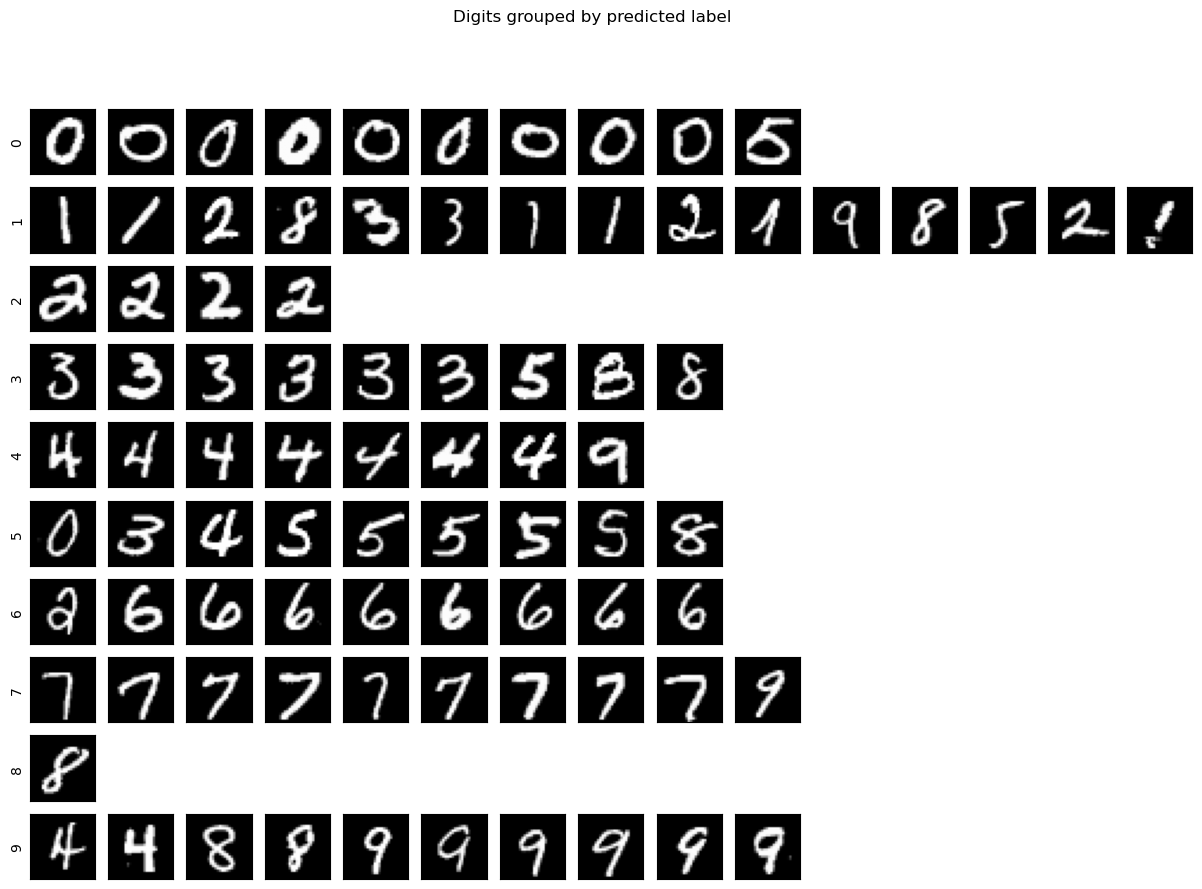

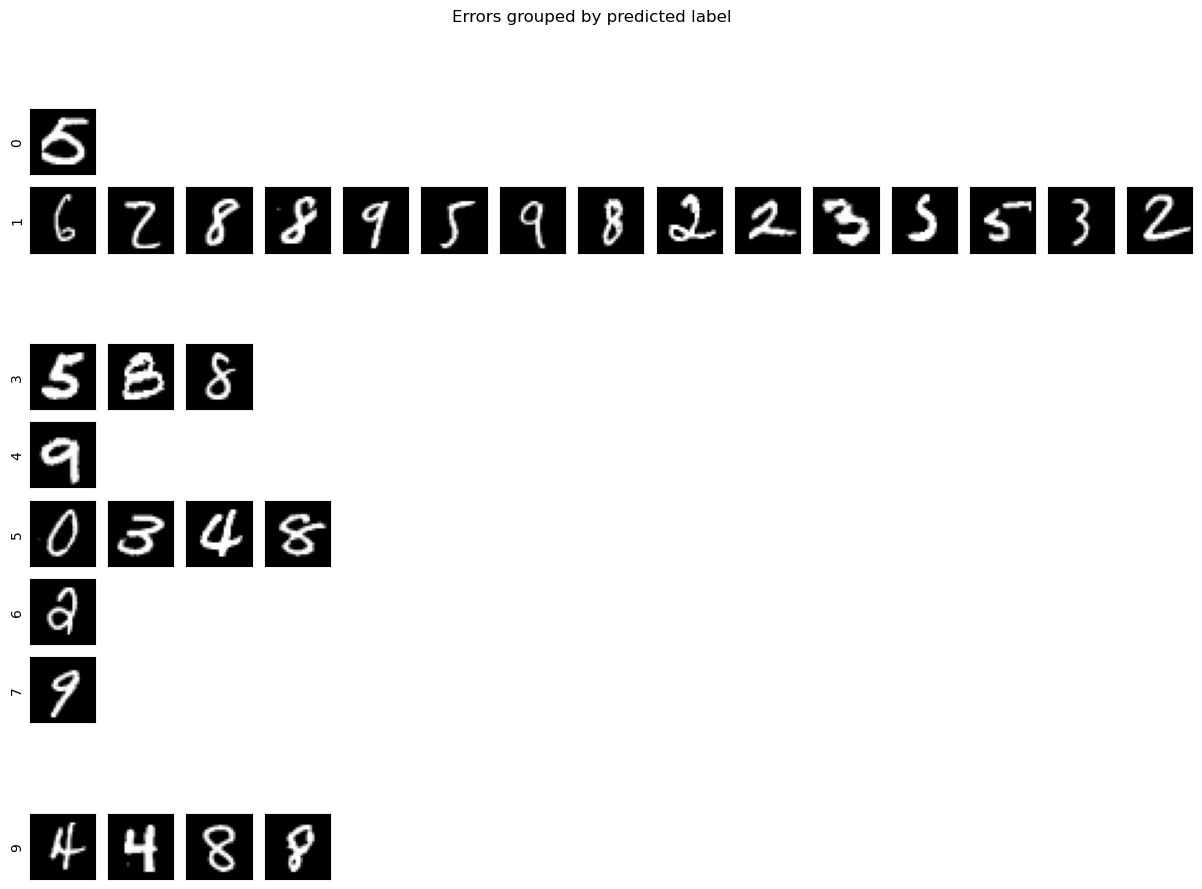

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.33      1.00      0.50        10
           2       1.00      0.40      0.57        10
           3       0.67      0.60      0.63        10
           4       0.88      0.70      0.78        10
           5       0.56      0.50      0.53        10
           6       0.89      0.80      0.84        10
           7       0.90      0.90      0.90        10
           8       1.00      0.10      0.18        10
           9       0.60      0.60      0.60        10

    accuracy                           0.65       100
   macro avg       0.77      0.65      0.64       100
weighted avg       0.77      0.65      0.64       100

[[ 9  0  0  0  0  1  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  5  4  0  0  0  1  0  0  0]
 [ 0  3  0  6  0  1  0  0  0  0]
 [ 0  0  0  0  7  1  0  0  0  2]
 [ 1  3  0  1  0  5  0  0  0  0]
 [ 0  2  0  0  0  0  8  0  0  0]
 [ 0  1  0

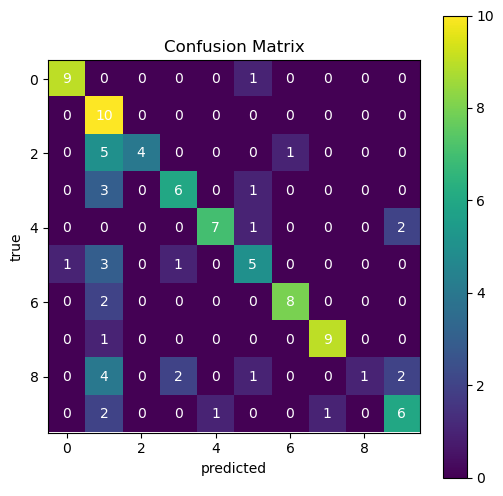

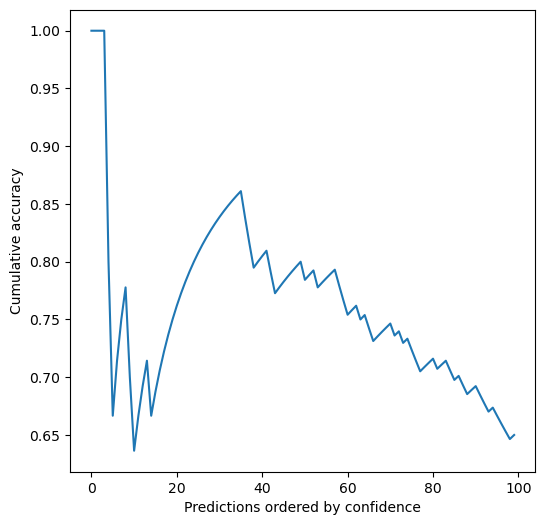

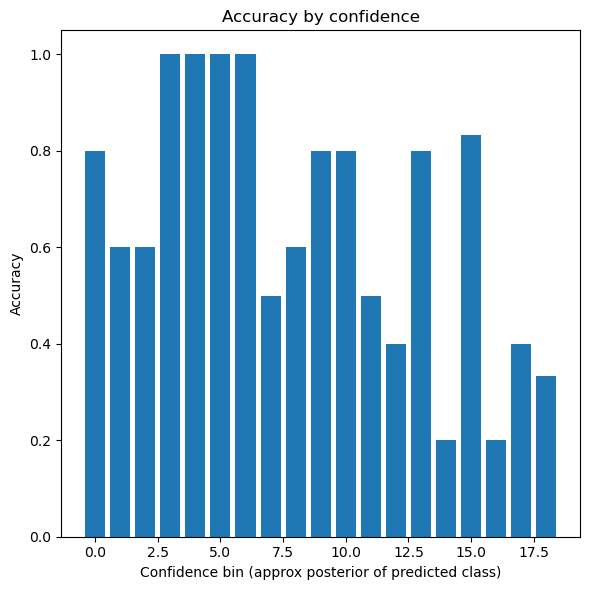

In [19]:

# Toggle between small subset and full set
use_small = True
X_tr = X_s if use_small else X_train
y_tr = y_s if use_small else y_train
X_te = Xtest_s if use_small else X_test
y_te = ytest_s if use_small else y_test

model_nb2 = nb_train(X_tr, y_tr, alpha=2)
pred_nb2 = nb_predict(model_nb2, X_te)
yhat = pred_nb2['yhat']
logprob = pred_nb2['logprob']

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print('Accuracy:', accuracy_score(y_te, yhat))

nextplot(); showdigits(X_te, yhat); plt.suptitle('Digits grouped by predicted label'); plt.show()

perror = (y_te != yhat)
nextplot(); showdigits(X_te[perror, :], yhat[perror]); plt.suptitle('Errors grouped by predicted label'); plt.show()

print(classification_report(y_te, yhat))
M = confusion_matrix(y_te, yhat)
print(M)
nextplot(); plt.imshow(M, origin='upper');
for (i, j), v in np.ndenumerate(M):
    plt.text(j, i, str(v), color='white', ha='center', va='center')
plt.xlabel('predicted'); plt.ylabel('true'); plt.colorbar(); plt.title('Confusion Matrix'); plt.show()

order = np.argsort(logprob)[::-1]
accuracies = np.cumsum(y_te[order] == yhat[order]) / (np.arange(len(yhat)) + 1)
nextplot(); plt.plot(accuracies); plt.xlabel('Predictions ordered by confidence'); plt.ylabel('Cumulative accuracy'); plt.show()

bins = (np.linspace(0, 1, 20) * len(yhat)).astype(int)
mean_accuracy = [
    np.mean(y_te[order][bins[i]:bins[i+1]] == yhat[order][bins[i]:bins[i+1]])
    for i in range(len(bins) - 1)
]
nextplot(); plt.bar(np.arange(len(mean_accuracy)), mean_accuracy)
plt.xlabel('Confidence bin (approx posterior of predicted class)'); plt.ylabel('Accuracy'); plt.title('Accuracy by confidence'); plt.tight_layout(); plt.show()


## 4) Model Selection — Cross-Validation over alpha

C:\Users\t00002k9\AppData\Local\Temp\ipykernel_2240\453640863.py:33: RuntimeWarning: divide by zero encountered in log
  return dict(logpriors=np.log(priors), logcls=np.log(cls))
C:\Users\t00002k9\AppData\Local\Temp\ipykernel_2240\2388475420.py:8: RuntimeWarning: invalid value encountered in subtract
  return (m + np.log(np.sum(np.exp(x - m), axis=axis, keepdims=True))).squeeze(axis)
C:\Users\t00002k9\AppData\Local\Temp\ipykernel_2240\453640863.py:33: RuntimeWarning: divide by zero encountered in log
  return dict(logpriors=np.log(priors), logcls=np.log(cls))
C:\Users\t00002k9\AppData\Local\Temp\ipykernel_2240\2388475420.py:8: RuntimeWarning: invalid value encountered in subtract
  return (m + np.log(np.sum(np.exp(x - m), axis=axis, keepdims=True))).squeeze(axis)
C:\Users\t00002k9\AppData\Local\Temp\ipykernel_2240\453640863.py:33: RuntimeWarning: divide by zero encountered in log
  return dict(logpriors=np.log(priors), logcls=np.log(cls))
C:\Users\t00002k9\AppData\Local\Temp\ipykernel_

alpha=  1.0: CV acc = 0.1000 ± 0.0303
alpha= 1.25: CV acc = 0.5433 ± 0.0768
alpha=  1.5: CV acc = 0.4783 ± 0.0768
alpha=  2.0: CV acc = 0.4100 ± 0.0981
alpha=  3.0: CV acc = 0.3600 ± 0.0999
alpha=  5.0: CV acc = 0.2917 ± 0.1171
alpha= 10.0: CV acc = 0.2450 ± 0.1229
Best alpha from CV: 1.25


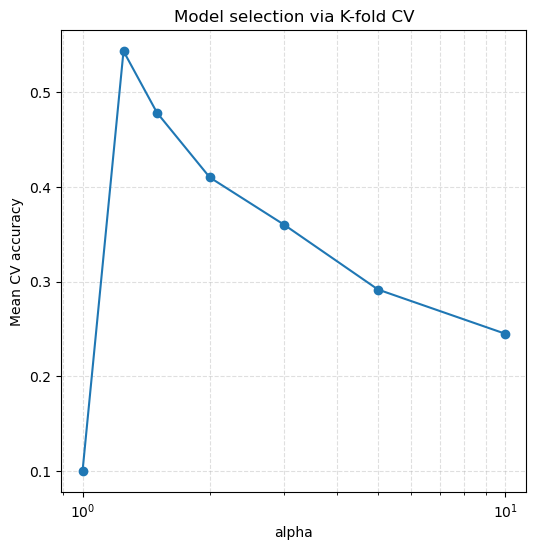

In [20]:

alphas = [1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]
K = 5
Kf = KFold(n_splits=K, shuffle=True, random_state=0)

X_cv = X_s  # use X_train for full-scale CV
y_cv = y_s

mean_acc = []
for alpha in alphas:
    accs = []
    for i_train, i_valid in Kf.split(X_cv):
        model = nb_train(X_cv[i_train], y_cv[i_train], alpha=alpha)
        pred = nb_predict(model, X_cv[i_valid])
        accs.append(sklearn.metrics.accuracy_score(y_cv[i_valid], pred['yhat']))
    mean_acc.append(np.mean(accs))
    print(f'alpha={alpha:>5}: CV acc = {np.mean(accs):.4f} ± {np.std(accs):.4f}')

best_alpha = alphas[int(np.argmax(mean_acc))]
print('Best alpha from CV:', best_alpha)

nextplot();
plt.plot(alphas, mean_acc, marker='o'); plt.xscale('log')
plt.xlabel('alpha'); plt.ylabel('Mean CV accuracy'); plt.title('Model selection via K-fold CV'); plt.grid(True, which='both', ls='--', alpha=0.4)
plt.show()


## 5) Generating Data — nb_generate

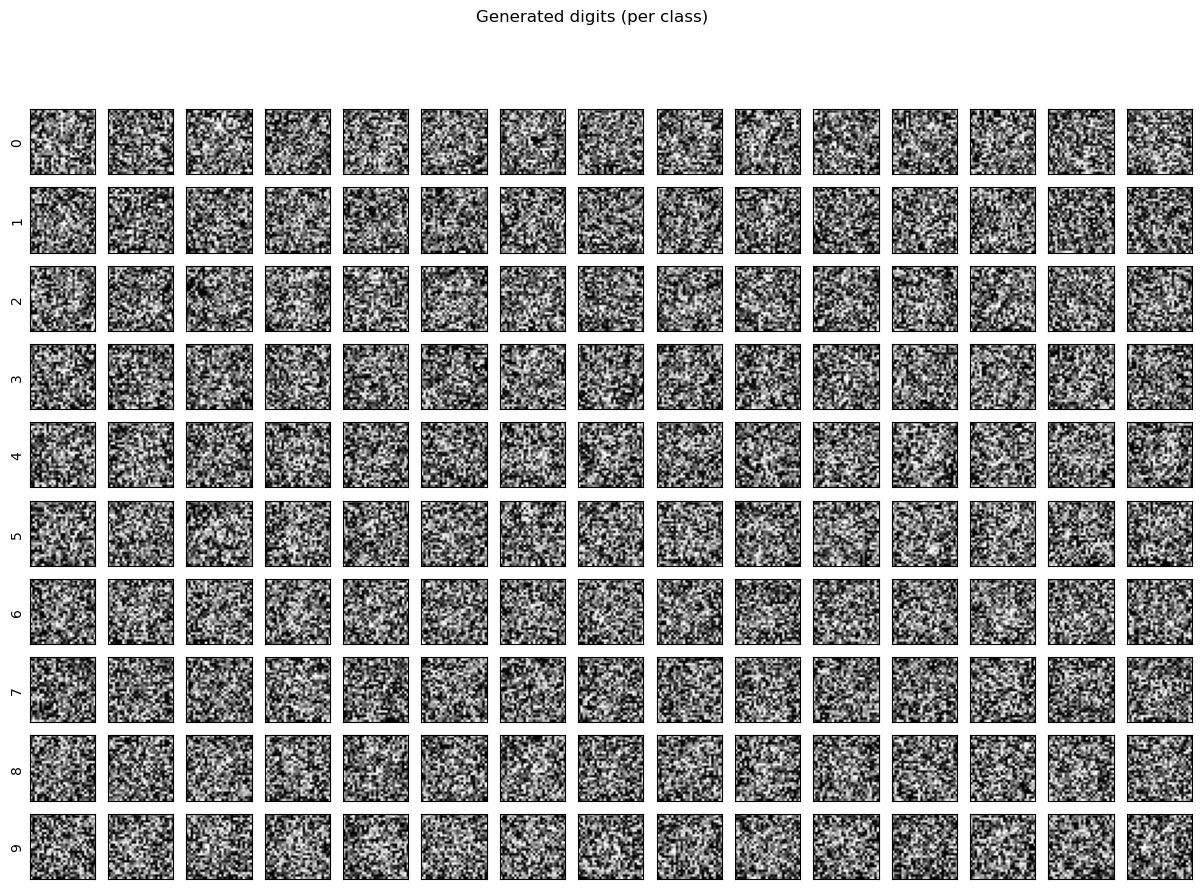

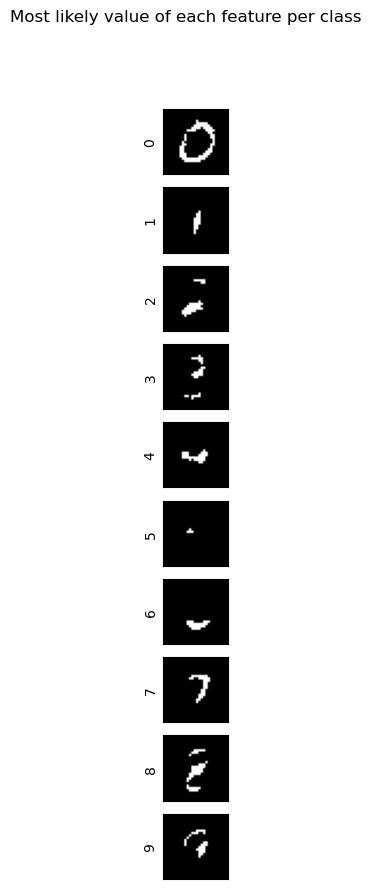

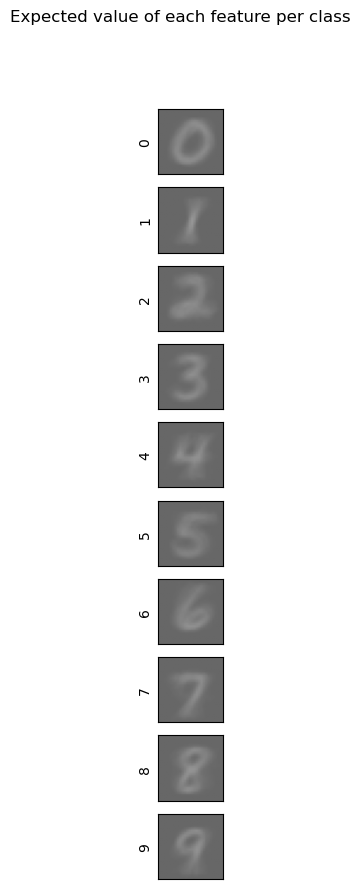

In [21]:

def nb_generate(model, ygen):
    logcls = model['logcls']
    ygen = np.asarray(ygen).astype(int)
    n = len(ygen)
    C, D, K = logcls.shape
    Xgen = np.zeros((n, D), dtype=np.int64)
    for i in range(n):
        c = ygen[i]
        theta = np.exp(logcls[c, :, :])
        for j in range(D):
            Xgen[i, j] = np.random.choice(np.arange(K), p=theta[j, :])
    return Xgen

# Generate and visualize
ygen = np.repeat(np.arange(10), 15)
Xgen = nb_generate(model_nb2, ygen)
nextplot(); showdigits(Xgen, ygen); plt.suptitle('Generated digits (per class)'); plt.show()

# Modes per feature
Xmax = np.zeros((10, D), dtype=int)
for c in range(10):
    Xmax[c, :] = np.apply_along_axis(np.argmax, 1, model_nb2['logcls'][c, :, :])
nextplot(); showdigits(Xmax, np.arange(10)); plt.suptitle('Most likely value of each feature per class'); plt.show()

# Expected value per feature (visual)
Xmean = np.zeros((10, D))
for c in range(10):
    Xmean[c, :] = np.apply_along_axis(lambda row: np.sum(np.exp(row) * np.arange(256)), 1, model_nb2['logcls'][c, :, :])
nextplot(); showdigits(Xmean, np.arange(10)); plt.suptitle('Expected value of each feature per class'); plt.show()
